Zipline Beginner Tutorial
=========================

Basics
------

Zipline is an open-source algorithmic trading simulator written in Python.

The source can be found at: https://github.com/stefan-jansen/zipline

Some benefits include:

* Realistic: slippage, transaction costs, order delays.
* Stream-based: Process each event individually, avoids look-ahead bias.
* Batteries included: Common transforms (moving average) as well as common risk calculations (Sharpe).

This tutorial assumes that you have zipline correctly installed, see the [installation instructions](https://github.com/stefan-jansen/zipline#installation) if you haven't set up zipline yet.

Every `zipline` algorithm consists of two functions you have to define:
* `initialize(context)`
* `handle_data(context, data)`

Before the start of the algorithm, `zipline` calls the `initialize()` function and passes in a `context` variable. `context` is a persistent namespace for you to store variables you need to access from one algorithm iteration to the next.

After the algorithm has been initialized, `zipline` calls the `handle_data()` function once for each event. At every call, it passes the same `context` variable and an event-frame called `data` containing the current trading bar with open, high, low, and close (OHLC) prices as well as volume for each stock in your universe.

In [1]:
import warnings
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore')

My first algorithm
----------------------

Lets take a look at a very simple algorithm from the `examples` directory, `buyapple.py`:

In [3]:
# assuming you're running this notebook in zipline/docs/notebooks
if os.name == 'nt':
    # windows doesn't have the cat command, but uses 'type' similarly
    ! type "..\..\zipline\examples\buyapple.py"
else:
    ! cat ../../zipline/examples/buyapple.py

#!/usr/bin/env python
#
# Copyright 2014 Quantopian, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from zipline.api import order, record, symbol
from zipline.finance import commission, slippage


def initialize(context):
    context.asset = symbol("AAPL")

    # Explicitly set the commission/slippage to the "old" value until we can
    # rebuild example data.
    # github.com/quantopian/zipline/blob/master/tests/resources/
    # rebuild_example_data#L105
    context.set_commission(commissi

As you can see, we first have to import some functions we would like to use. All functions commonly used in your algorithm can be found in `zipline.api`. Here we are using `order()` which takes two arguments -- a security object, and a number specifying how many stocks you would like to order (if negative, `order()` will sell/short stocks). In this case we want to order 10 shares of Apple at each iteration. For more documentation on `order()`, see the [Quantopian docs](https://www.quantopian.com/help#api-order).

Finally, the `record()` function allows you to save the value of a variable at each iteration. You provide it with a name for the variable together with the variable itself: `varname=var`. After the algorithm finished running you will have access to each variable value you tracked with `record()` under the name you provided (we will see this further below). You also see how we can access the current price data of the AAPL stock in the `data` event frame (for more information see [here](https://www.quantopian.com/help#api-event-properties)).

## Ingesting data for your algorithm

Before we can run the algorithm, we'll need some historical data for our algorithm to ingest, which we can get through a data bundle. A data bundle is a collection of pricing data, adjustment data, and an asset database. Bundles allow us to preload all of the data we will need to run backtests and store the data for future runs. Quantopian provides a default bundle called `quandl` which uses the [Quandl WIKI Dataset](https://www.quandl.com/data/WIKI-Wiki-EOD-Stock-Prices). You'll need a [Quandl API Key](https://docs.quandl.com/docs#section-authentication), and then you can ingest that data by running:

In [ ]:
!QUANDL_API_KEY=$QUANDL_API_KEY zipline ingest -b quandl

For more information on data bundles, such as building custom data bundles, you can look at the [zipline docs](https://www.zipline.ml4trading.io/bundles.html). 

## Running the algorithm

To now test this algorithm on financial data, `zipline` provides two interfaces. A command-line interface and an `IPython Notebook` interface.

### Command line interface
After you installed zipline you should be able to execute the following from your command line (e.g. `cmd.exe` on Windows, or the Terminal app on OSX):

In [7]:
!zipline run --help

Usage: zipline run [OPTIONS]

  Run a backtest for the given algorithm.

Options:
  -f, --algofile FILENAME         The file that contains the algorithm to run.
  -t, --algotext TEXT             The algorithm script to run.
  -D, --define TEXT               Define a name to be bound in the namespace
                                  before executing the algotext. For example
                                  '-Dname=value'. The value may be any python
                                  expression. These are evaluated in order so
                                  they may refer to previously defined names.

  --data-frequency [minute|daily]
                                  The data frequency of the simulation.
                                  [default: daily]

  --capital-base FLOAT            The starting capital for the simulation.
                                  [default: 10000000.0]

  -b, --bundle BUNDLE-NAME        The data bundle to use for the simulation.
                    

Note that you have to omit the preceding '!' when you call `run_algo.py`, this is only required by the IPython Notebook in which this tutorial was written.

As you can see there are a couple of flags that specify where to find your algorithm (`-f`) as well as the time-range (`--start` and `--end`). Finally, you'll want to save the performance metrics of your algorithm so that you can analyze how it performed. This is done via the `--output` flag and will cause it to write the performance `DataFrame` in the pickle Python file format.

Thus, to execute our algorithm from above and save the results to `buyapple_out.pickle` we would call `run_algo.py` as follows:

In [8]:
!zipline run -f ../../zipline/examples/buyapple.py --start 2016-1-1 --end 2018-1-1 -o buyapple_out.pickle --no-benchmark

[2021-03-26 20:51:42.751109] INFO: zipline.finance.metrics.tracker: Simulated 503 trading days
first open: 2016-01-04 14:31:00+00:00
last close: 2017-12-29 21:00:00+00:00
Figure(1800x800)


`run_algo.py` first outputs the algorithm contents. It then uses historical price and volume data of Apple from the `quantopian-quandl` bundle in the desired time range, calls the `initialize()` function, and then streams the historical stock price day-by-day through `handle_data()`. After each call to `handle_data()` we instruct `zipline` to order 10 stocks of AAPL. After the call of the `order()` function, `zipline` enters the ordered stock and amount in the order book. After the `handle_data()` function has finished, `zipline` looks for any open orders and tries to fill them. If the trading volume is high enough for this stock, the order is executed after adding the commission and applying the slippage model which models the influence of your order on the stock price, so your algorithm will be charged more than just the stock price * 10. (Note, that you can also change the commission and slippage model that `zipline` uses, see the [Quantopian docs](https://www.quantopian.com/help#ide-slippage) for more information).

Note that there is also an `analyze()` function printed. `run_algo.py` will try and look for a file with the ending with `_analyze.py` and the same name of the algorithm (so `buyapple_analyze.py`) or an `analyze()` function directly in the script. If an `analyze()` function is found it will be called *after* the simulation has finished and passed in the performance `DataFrame`. (The reason for allowing specification of an `analyze()` function in a separate file is that this way `buyapple.py` remains a valid Quantopian algorithm that you can copy&paste to the platform).

Lets take a quick look at the performance `DataFrame`. For this, we use `pandas` from inside the IPython Notebook and print the first ten rows. Note that `zipline` makes heavy usage of `pandas`, especially for data input and outputting so it's worth spending some time to learn it.

In [9]:
perf = pd.read_pickle('buyapple_out.pickle') # read in perf DataFrame
perf.head()

,period_open,period_close,returns,portfolio_value,longs_count,shorts_count,long_value,short_value,long_exposure,pnl,...,benchmark_volatility,alpha,beta,sharpe,sortino,max_drawdown,max_leverage,excess_return,treasury_period_return,trading_days
2016-01-04 21:00:00+00:00,2016-01-04 14:31:00+00:00,2016-01-04 21:00:00+00:00,0.000000e+00,10000000.0,0,0,0.0,0.0,0.0,0.0,...,NaN,None,None,NaN,NaN,0.000000e+00,0.000000,0.0,0.0,1
2016-01-05 21:00:00+00:00,2016-01-05 14:31:00+00:00,2016-01-05 21:00:00+00:00,-1.000000e-07,9999999.0,1,0,1027.1,0.0,1027.1,-1.0,...,0.0,None,None,-11.224972,-11.224972,-1.000000e-07,0.000103,0.0,0.0,2
2016-01-06 21:00:00+00:00,2016-01-06 14:31:00+00:00,2016-01-06 21:00:00+00:00,-2.110000e-06,9999977.9,1,0,2014.0,0.0,2014.0,-21.1,...,0.0,None,None,-9.823839,-9.588756,-2.210000e-06,0.000201,0.0,0.0,3
2016-01-07 21:00:00+00:00,2016-01-07 14:31:00+00:00,2016-01-07 21:00:00+00:00,-8.600019e-06,9999891.9,1,0,2893.5,0.0,2893.5,-86.0,...,0.0,None,None,-10.592737,-9.688947,-1.081000e-05,0.000289,0.0,0.0,4
2016-01-08 21:00:00+00:00,2016-01-08 14:31:00+00:00,2016-01-08 21:00:00+00:00,1.430015e-06,9999906.2,1,0,3878.4,0.0,3878.4,14.3,...,0.0,None,None,-7.511729,-7.519659,-1.081000e-05,0.000388,0.0,0.0,5


As you can see, there is a row for each trading day, starting on the first business day of 2016. In the columns you can find various information about the state of your algorithm. The very first column `AAPL` was placed there by the `record()` function mentioned earlier and allows us to plot the price of apple. For example, we could easily examine now how our portfolio value changed over time compared to the AAPL stock price.

Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'AAPL Stock Price')

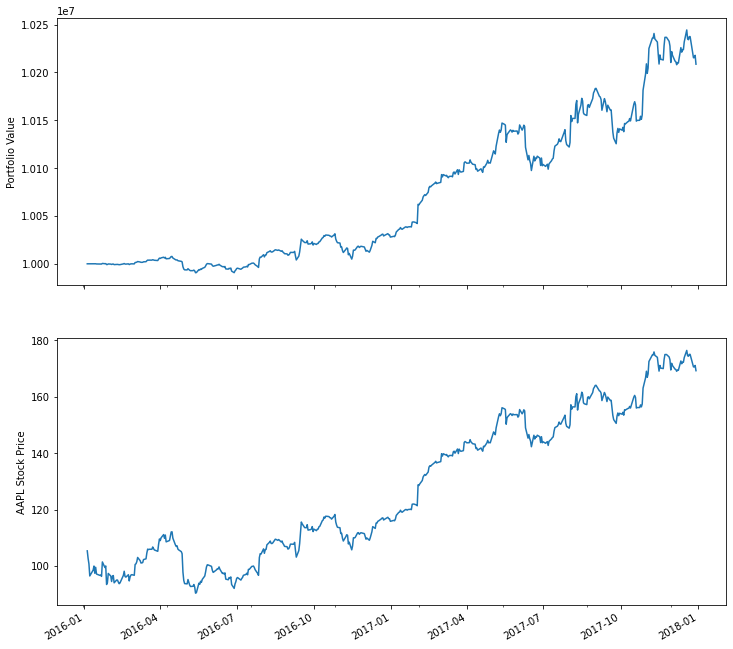

In [10]:
%pylab inline
figsize(12, 12)

ax1 = plt.subplot(211)
perf.portfolio_value.plot(ax=ax1)
ax1.set_ylabel('Portfolio Value')
ax2 = plt.subplot(212, sharex=ax1)
perf.AAPL.plot(ax=ax2)
ax2.set_ylabel('AAPL Stock Price')

As you can see, our algorithm performance as assessed by the `portfolio_value` closely matches that of the AAPL stock price. This is not surprising as our algorithm only bought AAPL every chance it got.

### Jupyter Notebook

The [Jupyter Notebook](https://jupyter.org) is a very powerful browser-based interface to a Python interpreter (this tutorial was written in it). As it is already the de-facto interface for most quantitative researchers `zipline` provides an easy way to run your algorithm inside the Notebook without requiring you to use the CLI. 

To use it you have to write your algorithm in a cell and let `zipline` know that it is supposed to run this algorithm. This is done via the `%%zipline` IPython magic command that is available after you run `%load_ext zipline` in a separate cell. This magic takes the same arguments as the command line interface described above.

In [11]:
%load_ext zipline

In [12]:
%%zipline --start 2016-1-1 --end 2018-1-1 -o perf_ipython.pickle --no-benchmark

from zipline.api import symbol, order, record

def initialize(context):
    context.asset = symbol('AAPL')

def handle_data(context, data):
    order(context.asset, 10)
    record(AAPL=data.current(context.asset, 'price'))

,period_open,period_close,longs_count,shorts_count,long_value,short_value,long_exposure,pnl,capital_used,short_exposure,...,beta,sharpe,sortino,max_drawdown,max_leverage,excess_return,treasury_period_return,trading_days,period_label,algorithm_period_return
2016-01-04 21:00:00+00:00,2016-01-04 14:31:00+00:00,2016-01-04 21:00:00+00:00,0,0,0.0,0.0,0.0,0.00000,0.00000,0.0,...,None,NaN,NaN,0.000000e+00,0.000000,0.0,0.0,1,2016-01,0.000000e+00
2016-01-05 21:00:00+00:00,2016-01-05 14:31:00+00:00,2016-01-05 21:00:00+00:00,1,0,1027.1,0.0,1027.1,-0.52355,-1027.62355,0.0,...,None,-11.224972,-11.224972,-5.235500e-08,0.000103,0.0,0.0,2,2016-01,-5.235500e-08
2016-01-06 21:00:00+00:00,2016-01-06 14:31:00+00:00,2016-01-06 21:00:00+00:00,1,0,2014.0,0.0,2014.0,-20.61350,-1007.51350,0.0,...,None,-9.516452,-9.394902,-2.113705e-06,0.000201,0.0,0.0,3,2016-01,-2.113705e-06
2016-01-07 21:00:00+00:00,2016-01-07 14:31:00+00:00,2016-01-07 21:00:00+00:00,1,0,2893.5,0.0,2893.5,-85.49225,-964.99225,0.0,...,None,-10.479703,-9.623685,-1.066293e-05,0.000289,0.0,0.0,4,2016-01,-1.066293e-05
2016-01-08 21:00:00+00:00,2016-01-08 14:31:00+00:00,2016-01-08 21:00:00+00:00,1,0,3878.4,0.0,3878.4,14.80520,-970.09480,0.0,...,None,-7.365239,-7.412520,-1.066293e-05,0.000388,0.0,0.0,5,2016-01,-9.182410e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22 21:00:00+00:00,2017-12-22 14:31:00+00:00,2017-12-22 21:00:00+00:00,1,0,871549.8,0.0,871549.8,-0.88505,-1750.98505,0.0,...,None,1.563884,2.500854,-5.682000e-03,0.085132,0.0,0.0,499,2017-12,2.376041e-02
2017-12-26 21:00:00+00:00,2017-12-26 14:31:00+00:00,2017-12-26 21:00:00+00:00,1,0,851144.3,0.0,851144.3,-22112.06285,-1706.56285,0.0,...,None,1.389702,2.159343,-5.682000e-03,0.085132,0.0,0.0,500,2017-12,2.154920e-02
2017-12-27 21:00:00+00:00,2017-12-27 14:31:00+00:00,2017-12-27 21:00:00+00:00,1,0,853000.0,0.0,853000.0,148.83700,-1706.86300,0.0,...,None,1.389258,2.158657,-5.682000e-03,0.085132,0.0,0.0,501,2017-12,2.156408e-02
2017-12-28 21:00:00+00:00,2017-12-28 14:31:00+00:00,2017-12-28 21:00:00+00:00,1,0,857110.8,0.0,857110.8,2399.13460,-1711.66540,0.0,...,None,1.402894,2.180178,-5.682000e-03,0.085132,0.0,0.0,502,2017-12,2.180400e-02


Note that we did not have to specify an input file as above since the magic will use the contents of the cell and look for your algorithm functions there.

In [13]:
pd.read_pickle('perf_ipython.pickle').head()

,period_open,period_close,longs_count,shorts_count,long_value,short_value,long_exposure,pnl,capital_used,short_exposure,...,beta,sharpe,sortino,max_drawdown,max_leverage,excess_return,treasury_period_return,trading_days,period_label,algorithm_period_return
2016-01-04 21:00:00+00:00,2016-01-04 14:31:00+00:00,2016-01-04 21:00:00+00:00,0,0,0.0,0.0,0.0,0.00000,0.00000,0.0,...,None,NaN,NaN,0.000000e+00,0.000000,0.0,0.0,1,2016-01,0.000000e+00
2016-01-05 21:00:00+00:00,2016-01-05 14:31:00+00:00,2016-01-05 21:00:00+00:00,1,0,1027.1,0.0,1027.1,-0.52355,-1027.62355,0.0,...,None,-11.224972,-11.224972,-5.235500e-08,0.000103,0.0,0.0,2,2016-01,-5.235500e-08
2016-01-06 21:00:00+00:00,2016-01-06 14:31:00+00:00,2016-01-06 21:00:00+00:00,1,0,2014.0,0.0,2014.0,-20.61350,-1007.51350,0.0,...,None,-9.516452,-9.394902,-2.113705e-06,0.000201,0.0,0.0,3,2016-01,-2.113705e-06
2016-01-07 21:00:00+00:00,2016-01-07 14:31:00+00:00,2016-01-07 21:00:00+00:00,1,0,2893.5,0.0,2893.5,-85.49225,-964.99225,0.0,...,None,-10.479703,-9.623685,-1.066293e-05,0.000289,0.0,0.0,4,2016-01,-1.066293e-05
2016-01-08 21:00:00+00:00,2016-01-08 14:31:00+00:00,2016-01-08 21:00:00+00:00,1,0,3878.4,0.0,3878.4,14.80520,-970.09480,0.0,...,None,-7.365239,-7.412520,-1.066293e-05,0.000388,0.0,0.0,5,2016-01,-9.182410e-06


## Access to previous prices using `data.history()`

### Working example: Dual Moving Average Cross-Over

The Dual Moving Average (DMA) is a classic momentum strategy. It's probably not used by any serious trader anymore but is still very instructive. The basic idea is that we compute two rolling or moving averages (mavg) -- one with a longer window that is supposed to capture long-term trends and one shorter window that is supposed to capture short-term trends. Once the short-mavg crosses the long-mavg from below we assume that the stock price has upwards momentum and long the stock. If the short-mavg crosses from above we exit the positions as we assume the stock to go down further.

As we need to have access to previous prices to implement this strategy we need a new concept: History

`data.history()` is a convenience function that keeps a rolling window of data for you. The first argument is the asset or iterable of assets you're using, the second argument is the field you're looking for i.e. price, open, volume, the third argument is the number of bars, and the fourth argument is your frequency (either `'1d'` for `'1m'` but note that you need to have minute-level data for using `1m`). 

Let's look at the strategy which should make this clear:

In [14]:
%pylab inline
figsize(12, 12)

Populating the interactive namespace from numpy and matplotlib


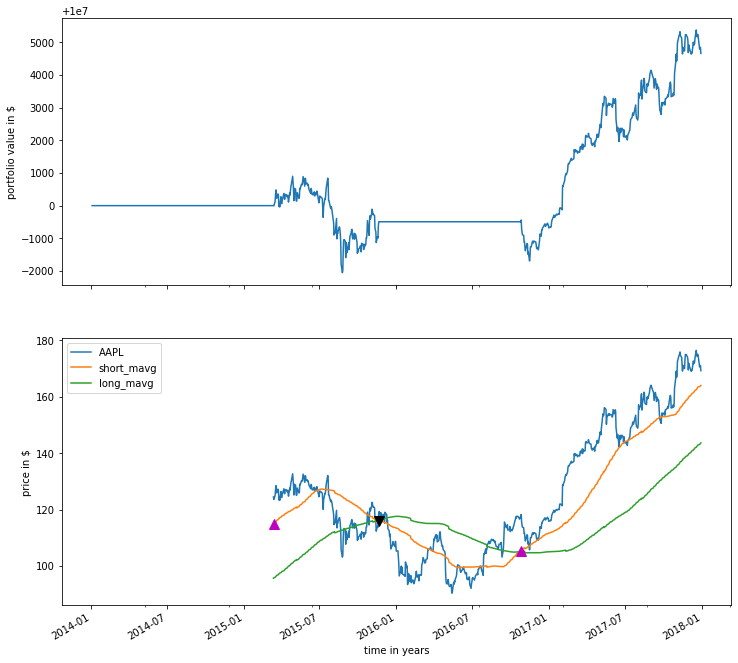

,period_open,period_close,long_value,short_value,ending_value,long_exposure,starting_exposure,portfolio_value,longs_count,short_exposure,...,algorithm_period_return,benchmark_period_return,benchmark_volatility,alpha,beta,sharpe,sortino,AAPL,short_mavg,long_mavg
2014-01-02 21:00:00+00:00,2014-01-02 14:31:00+00:00,2014-01-02 21:00:00+00:00,0.0,0.0,0.0,0.0,0.0,1.000000e+07,0,0.0,...,0.000000,0.0,NaN,None,None,NaN,NaN,NaN,NaN,NaN
2014-01-03 21:00:00+00:00,2014-01-03 14:31:00+00:00,2014-01-03 21:00:00+00:00,0.0,0.0,0.0,0.0,0.0,1.000000e+07,0,0.0,...,0.000000,0.0,0.0,None,None,NaN,NaN,NaN,NaN,NaN
2014-01-06 21:00:00+00:00,2014-01-06 14:31:00+00:00,2014-01-06 21:00:00+00:00,0.0,0.0,0.0,0.0,0.0,1.000000e+07,0,0.0,...,0.000000,0.0,0.0,None,None,NaN,NaN,NaN,NaN,NaN
2014-01-07 21:00:00+00:00,2014-01-07 14:31:00+00:00,2014-01-07 21:00:00+00:00,0.0,0.0,0.0,0.0,0.0,1.000000e+07,0,0.0,...,0.000000,0.0,0.0,None,None,NaN,NaN,NaN,NaN,NaN
2014-01-08 21:00:00+00:00,2014-01-08 14:31:00+00:00,2014-01-08 21:00:00+00:00,0.0,0.0,0.0,0.0,0.0,1.000000e+07,0,0.0,...,0.000000,0.0,0.0,None,None,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22 21:00:00+00:00,2017-12-22 14:31:00+00:00,2017-12-22 21:00:00+00:00,17501.0,0.0,17501.0,17501.0,17501.0,1.000524e+07,1,0.0,...,0.000524,0.0,0.0,None,None,0.687600,1.012820,175.01,163.442190,142.891860
2017-12-26 21:00:00+00:00,2017-12-26 14:31:00+00:00,2017-12-26 21:00:00+00:00,17057.0,0.0,17057.0,17057.0,17501.0,1.000479e+07,1,0.0,...,0.000479,0.0,0.0,None,None,0.624704,0.913225,170.57,163.598280,143.075387
2017-12-27 21:00:00+00:00,2017-12-27 14:31:00+00:00,2017-12-27 21:00:00+00:00,17060.0,0.0,17060.0,17060.0,17057.0,1.000480e+07,1,0.0,...,0.000480,0.0,0.0,None,None,0.624784,0.913342,170.60,163.746503,143.259273
2017-12-28 21:00:00+00:00,2017-12-28 14:31:00+00:00,2017-12-28 21:00:00+00:00,17108.0,0.0,17108.0,17108.0,17060.0,1.000484e+07,1,0.0,...,0.000484,0.0,0.0,None,None,0.630682,0.922021,171.08,163.899520,143.445907


In [15]:
%%zipline --start 2014-1-1 --end 2018-1-1 -o perf_dma.pickle --no-benchmark

from zipline.api import order_target, record, symbol
import numpy as np
import matplotlib.pyplot as plt

def initialize(context):
    context.i = 0
    context.asset = symbol('AAPL')


def handle_data(context, data):
    # Skip first 300 days to get full windows
    context.i += 1
    if context.i < 300:
        return

    # Compute averages
    # data.history() has to be called with the same params
    # from above and returns a pandas dataframe.
    short_mavg = data.history(context.asset, 'price', bar_count=100, frequency="1d").mean()
    long_mavg = data.history(context.asset, 'price', bar_count=300, frequency="1d").mean()

    # Trading logic
    if short_mavg > long_mavg:
        # order_target orders as many shares as needed to
        # achieve the desired number of shares.
        order_target(context.asset, 100)
    elif short_mavg < long_mavg:
        order_target(context.asset, 0)

    # Save values for later inspection
    record(AAPL=data.current(context.asset, 'price'),
           short_mavg=short_mavg,
           long_mavg=long_mavg)


def analyze(context, perf):
    ax1 = plt.subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('portfolio value in $')
    ax1.set_xlabel('time in years')

    ax2 = plt.subplot(212, sharex=ax1)

    perf['AAPL'].plot(ax=ax2)
    perf[['short_mavg', 'long_mavg']].plot(ax=ax2)

    perf_trans = perf.loc[[t != [] for t in perf.transactions]]
    buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
    sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
    ax2.plot(buys.index, perf.short_mavg.loc[buys.index], '^', markersize=10, color='m')
    ax2.plot(sells.index, perf.short_mavg.loc[sells.index],'v', markersize=10, color='k')
    ax2.set_ylabel('price in $')
    ax2.set_xlabel('time in years')
    plt.legend(loc=0)
    plt.show()

Here we are explicitly defining an `analyze()` function that gets automatically called once the backtest is done (this is not possible on Quantopian currently).

Although it might not be directly apparent, the power of `history` (pun intended) can not be under-estimated as most algorithms make use of prior market developments in one form or another. You could easily devise a strategy that trains a classifier with [`scikit-learn`](http://scikit-learn.org/stable/) which tries to predict future market movements based on past prices (note, that most of the `scikit-learn` functions require `numpy.ndarray`s rather than `pandas.DataFrame`s, so you can simply pass the underlying `ndarray` of a `DataFrame` via `.values`).

We also used the `order_target()` function above. This and other functions like it can make order management and portfolio rebalancing much easier.

# Conclusions

We hope that this tutorial gave you a little insight into the architecture, API, and features of `zipline`. For next steps, check out some of the [examples](https://github.com/stefan-jansen/zipline/tree/master/src/zipline/examples).

Feel free to ask questions on [our mailing list](https://groups.google.com/forum/#!forum/zipline), report problems on our [GitHub issue tracker](https://github.com/stefan-jansen/zipline/issues?state=open), and [join our community](https://exchange.ml4trading.io).